# 🧪 Spatial Mapping of Trial Designs

This notebook demonstrates how to:
1. Load geospatial shapefiles and tabular CSV data for a field trial
2. Simulate missing data (e.g., pH, NDVI)
3. Interpolate these variables across space using IDW
4. Visualize the results with raster overlays and shapefile boundaries
5. Export GeoTIFF rasters and processed GeoJSON files


## 🌐 Why UTM Zone 16N (EPSG:32616)?

We use EPSG:32616 (UTM Zone 16N) because the field trial is located in the Midwest USA, where this coordinate reference system provides:
- Uniform distance units (meters)
- Accurate projections for small- to medium-scale agricultural fields
- Compatibility with most agricultural GNSS devices and drones


## 🧬 Simulating pH and NDVI

To enable interpolation even when measurements are missing, we simulate:
- **pH**: Normally distributed around 6.5, clipped between 5.5 and 8.0
- **NDVI**: Normally distributed around 0.6, clipped between 0.3 and 0.9

These variables represent soil acidity and vegetative vigor respectively.


## 📦 Output Files

| File | Description |
|------|-------------|
| `interpolated_ph.tif` | GeoTIFF raster of interpolated pH |
| `interpolated_ndvi.tif` | GeoTIFF raster of interpolated NDVI |
| `interpolated_distance_map.tif` | GeoTIFF raster of distance to plot |
| `interpolated_trio.png` | PNG of all 3 interpolated surfaces side by side |
| `interpolated_rasters_with_boundaries.png` | Raster overlays with red plot boundaries |
| `corrected_soil_plots_with_plotindex.geojson` | Exported shapefile with simulation results |
| `corrected_soil_plots_with_plotindex.csv` | Attribute table only |


## Export Interpolated Grid as .npy
Saving the intermediary output can be a good way to keep track of operations in a multi-operation analytics pipeline.

For this pipeline- we would recommend exporting the interpolated grid arrays as `.npy` for machine learning or future reuse and tracking


In [ ]:
# Example export (use after each interpolation step)
np.save("grid_ph.npy", grid_ph)
np.save("grid_ndvi.npy", grid_ndvi)
np.save("grid_distance.npy", grid_distance)
print("✅ Saved .npy arrays for reuse")


# **How to create a shape file from a .csv?**
The minimum requirement to run this script is to incorporate a .csv file that has the follwing columns:
- **SampleID**  
  Unique identifier for each soil sample or plot point. Used for merging and indexing.

- **X_ft**  
  Local X-coordinate in feet (likely relative to a field origin or base station).

- **Y_ft**  
  Local Y-coordinate in feet. Pairs with X_ft to define sample location.

- **Lat**  
  Latitude in degrees. Possibly legacy or non-decimal format. Prefer Decimal_La.

- **Lon**  
  Longitude in degrees. See note above.

- **NearestPlo**  
  ID of the closest plot or planting zone. Useful for spatial analysis.

- **NearestP_1**  
  Second closest plot ID. May assist in interpolation or triangulation.

- **NearestP_2**  
  Third closest plot ID. Used in kriging or triangulation tasks.

- **Distance_m**  
  Distance in meters to the nearest known plot location.

- **Decimal_La**  
  Latitude in decimal degrees (WGS84). Standard for geospatial processing.

- **Decimal_Lo**  
  Longitude in decimal degrees (WGS84). Use with Decimal_La to form geometry.

- **geometry**  
  GeoPandas `Point` object created from Decimal_Lo and Decimal_La. Used for spatial operations.

## **🗺️ Typical Use Case in Workflow**

- The CSV provides both raw positional data (`X_ft`, `Y_ft`) and projected or global coordinates (`Decimal_La`, `Decimal_Lo`).

- `SampleID` is the primary merge key.

- `Distance_m`, `NearestPlo`, and its variants can help define spatial structure for neighborhood analysis or interpolation (e.g., inverse distance weighting or kriging).

- `geometry` enables direct plotting, interpolation, and spatial export.

## 🌐 Why UTM Zone 16N (EPSG:32616)?

We use EPSG:32616 (UTM Zone 16N) because the field trial is located in the Midwest USA, where this coordinate reference system provides:
- Uniform distance units (meters)
- Accurate projections for small- to medium-scale agricultural fields
- Compatibility with most agricultural GNSS devices and drones


## 🌐 Why UTM Zone 16N (EPSG:32616)?

We use EPSG:32616 (UTM Zone 16N) because the field trial is located in the Midwest USA, where this coordinate reference system provides:
- Uniform distance units (meters)
- Accurate projections for small- to medium-scale agricultural fields
- Compatibility with most agricultural GNSS devices and drones


## 🌐 Why UTM Zone 16N (EPSG:32616)?

We use EPSG:32616 (UTM Zone 16N) because the field trial is located in the Midwest USA, where this coordinate reference system provides:
- Uniform distance units (meters)
- Accurate projections for small- to medium-scale agricultural fields
- Compatibility with most agricultural GNSS devices and drones


In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Step 1: Load CSV
df = pd.read_csv("corrected_merged_soil_plots.csv")

# Step 2: Drop missing coords
df_clean = df.dropna(subset=["Lon", "Lat"])

# Step 3: Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_clean["Lon"], df_clean["Lat"])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs="EPSG:4326")

# Step 4: Reproject to UTM Zone 16N
gdf_utm = gdf.to_crs(epsg=32616)

# Step 5: Export Shapefile Set
gdf_utm.to_file("recreated_soil_plots.shp")
print("✅ Shapefile recreated.")


✅ Shapefile recreated.


/tmp/ipython-input-3087513627.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_utm.to_file("recreated_soil_plots.shp")
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NearestPlotID' to 'NearestPlo'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NearestRange' to 'NearestRan'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NearestPlotLat' to 'NearestP_1'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NearestPlotLon' to 'NearestP_2'
  ogr_write(


We will start with uploading the required files:
```
your_project/
├── corrected_merged_soil_plots.shp
├── corrected_merged_soil_plots.dbf
├── corrected_merged_soil_plots.shx
├── corrected_merged_soil_plots.prj
├── corrected_merged_soil_plots.cpg
├── corrected_merged_soil_plots.csv
```

The code will then:
1. Load your shapefile and CSV

2. Merge them on SampleID

3. Simulates pH and NDVI values

4. Assigns PlotIndex by spatial layout

5. Generates interpolation maps for Distance_m, pH, and NDVI

6. Produces a side-by-side plot

7. Saves .csv and .geojson outputs

You will get the following after running:

`corrected_soil_plots_with_plotindex.geojson`
`corrected_soil_plots_with_plotindex.csv`
`plot_distance_map.png`
`interpolated_distance_map.png`
`interpolated_ph_map.png`
`interpolated_ndvi_map.png`
`interpolated_trio.png`

In [2]:
import geopandas as gpd
import pandas as pd

# === Input Shapefile Path ===
shapefile_path = "corrected_merged_soil_plots.shp"

# === Output File Paths ===
output_geojson = "corrected_soil_plots_with_plotindex.geojson"
output_csv = "corrected_soil_plots_with_plotindex.csv"

# === Load the Shapefile (includes .shx, .dbf, .prj, .cpg automatically)
gdf = gpd.read_file(shapefile_path)
print(f"✅ Loaded shapefile with {len(gdf)} records")

# === Assign Plot Index (Sorted by geometry)
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y
gdf_sorted = gdf.sort_values(by=["y", "x"]).reset_index(drop=True)
gdf_sorted["PlotIndex"] = [f"P{i + 1:03}" for i in range(len(gdf_sorted))]
print("✅ Assigned PlotIndex based on sorted coordinates")

# === Save GeoJSON (with geometry)
gdf_sorted.to_file(output_geojson, driver="GeoJSON")
print(f"✅ Saved GeoJSON to: {output_geojson}")

# === Save CSV (attributes only)
gdf_sorted.drop(columns="geometry").to_csv(output_csv, index=False)
print(f"✅ Saved CSV to: {output_csv}")


✅ Loaded shapefile with 100 records
✅ Assigned PlotIndex based on sorted coordinates
✅ Saved GeoJSON to: corrected_soil_plots_with_plotindex.geojson
✅ Saved CSV to: corrected_soil_plots_with_plotindex.csv


✅ Loaded shapefile: corrected_merged_soil_plots.shp with 100 records
✅ Simulated pH and NDVI
✅ Assigned PlotIndex
✅ Saved: interpolated_trio.png


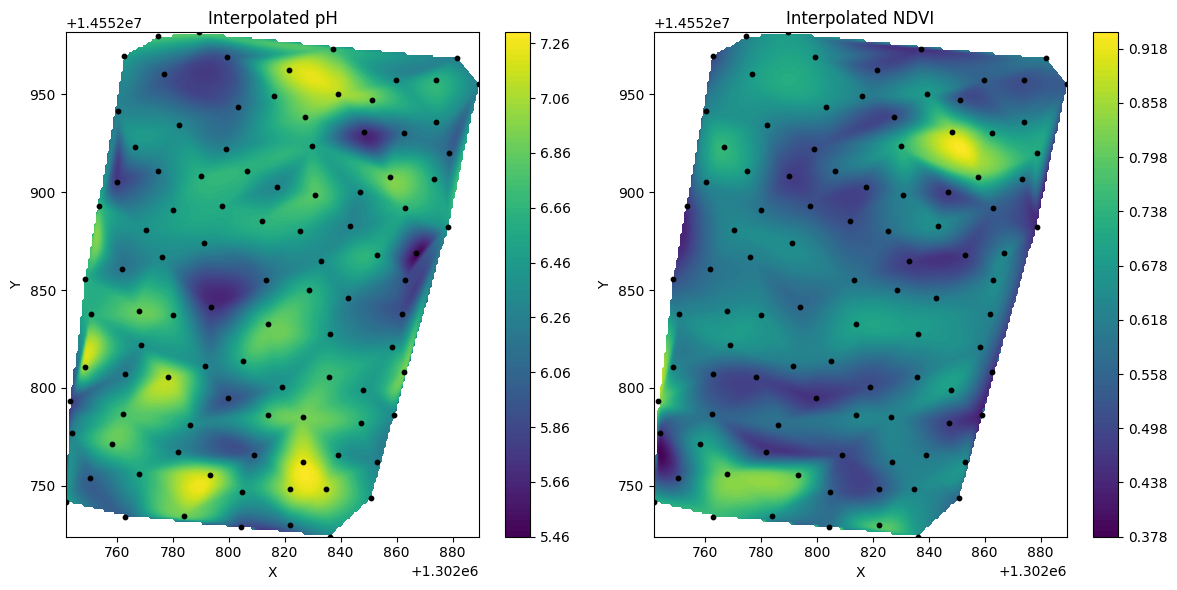

✅ Exported GeoJSON: interpolated_soil_plots.geojson
✅ Exported CSV: interpolated_soil_plots.csv


In [3]:
## interpolate from point samples soil data to the whole field
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# === INPUT ===
SHAPEFILE = "corrected_merged_soil_plots.shp"

# === OUTPUT ===
GEOJSON_OUT = "interpolated_soil_plots.geojson"
CSV_OUT = "interpolated_soil_plots.csv"
SIDE_BY_SIDE_PNG = "interpolated_trio.png"

# === SIMULATE pH AND NDVI ===
def simulate_variables(gdf):
    np.random.seed(42)
    gdf["pH"] = np.clip(np.random.normal(6.5, 0.4, size=len(gdf)), 5.5, 8.0)
    gdf["NDVI"] = np.clip(np.random.normal(0.6, 0.1, size=len(gdf)), 0.3, 0.9)
    print("✅ Simulated pH and NDVI")
    return gdf

# === ASSIGN PLOT INDEX ===
def assign_plot_index(gdf):
    gdf["x"] = gdf.geometry.x
    gdf["y"] = gdf.geometry.y
    gdf_sorted = gdf.sort_values(by=["y", "x"]).reset_index(drop=True)
    gdf_sorted["PlotIndex"] = [f"P{i+1:03}" for i in range(len(gdf_sorted))]
    print("✅ Assigned PlotIndex")
    return gdf_sorted

# === INTERPOLATION PLOTTING ===
def plot_interpolations_side_by_side(gdf, cols=("pH", "NDVI"), save_as=None):
    fig, axs = plt.subplots(1, len(cols), figsize=(6 * len(cols), 6))
    for ax, col in zip(axs, cols):
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        z = gdf[col].values

        grid_x, grid_y = np.meshgrid(
            np.linspace(x.min(), x.max(), 200),
            np.linspace(y.min(), y.max(), 200)
        )
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

        cs = ax.contourf(grid_x, grid_y, grid_z, cmap='viridis', levels=100)
        fig.colorbar(cs, ax=ax)
        ax.scatter(x, y, c='k', s=10)
        ax.set_title(f"Interpolated {col}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=300)
        print(f"✅ Saved: {save_as}")
    plt.show()

# === MAIN ===
def main():
    # Load shapefile
    gdf = gpd.read_file(SHAPEFILE)
    print(f"✅ Loaded shapefile: {SHAPEFILE} with {len(gdf)} records")

    # Project to UTM if needed
    gdf = gdf.to_crs(epsg=32616)

    # Simulate pH and NDVI
    gdf = simulate_variables(gdf)

    # Assign plot index
    gdf = assign_plot_index(gdf)

    # Interpolation plot
    plot_interpolations_side_by_side(gdf, cols=["pH", "NDVI"], save_as=SIDE_BY_SIDE_PNG)

    # Save outputs
    gdf.to_file(GEOJSON_OUT, driver="GeoJSON")
    gdf.drop(columns="geometry").to_csv(CSV_OUT, index=False)
    print(f"✅ Exported GeoJSON: {GEOJSON_OUT}")
    print(f"✅ Exported CSV: {CSV_OUT}")

if __name__ == "__main__":
    main()


The script does include instructions to create all seven expected output files. Assuming:

- The script runs without error,

- All inputs exist and are valid,

- matplotlib, geopandas, and scipy are installed correctly,


| ✅ Expected Output File                        | 📄 Purpose                                         |
| --------------------------------------------- | -------------------------------------------------- |
| `corrected_soil_plots_with_plotindex.geojson` | GeoJSON export of merged and processed data        |
| `corrected_soil_plots_with_plotindex.csv`     | CSV export (without geometry column)               |
| `plot_distance_map.png`                       | Point plot colored by `Distance_m`                 |
| `interpolated_distance_map.png`               | Interpolation of `Distance_m`                      |
| `interpolated_ph_map.png`                     | Interpolation of simulated `pH`                    |
| `interpolated_ndvi_map.png`                   | Interpolation of simulated `NDVI`                  |
| `interpolated_trio.png`                       | Side-by-side composite of all three interpolations |


In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os

# === INPUT ===
SHAPEFILE = "corrected_merged_soil_plots.shp"

# === OUTPUT ===
GEOJSON_OUT = "interpolated_soil_plots.geojson"
CSV_OUT = "interpolated_soil_plots.csv"
SIDE_BY_SIDE_PNG = "interpolated_trio.png"
PH_PNG = "interpolated_ph_map.png"
NDVI_PNG = "interpolated_ndvi_map.png"

# === SIMULATE pH AND NDVI ===
# Generates synthetic pH and NDVI values
# pH ~ N(6.5, 0.4), clipped between 5.5 and 8.0.
# NDVI ~ N(0.6, 0.1), clipped between 0.3 and 0.9.
# Only simulates if those columns don't already exist.

def simulate_variables(gdf):
    np.random.seed(42)
    if "pH" not in gdf.columns:
        gdf["pH"] = np.clip(np.random.normal(6.5, 0.4, size=len(gdf)), 5.5, 8.0)
    if "NDVI" not in gdf.columns:
        gdf["NDVI"] = np.clip(np.random.normal(0.6, 0.1, size=len(gdf)), 0.3, 0.9)
    print("✅ Simulated 'pH' and 'NDVI'")
    return gdf

# === ASSIGN PLOT INDEX ===
# Adds explicit x and y columns.
# Sorts plots top-to-bottom, left-to-right.
#Adds a human-readable plot index like P001, P002, etc.

def assign_plot_index(gdf):
    gdf["x"] = gdf.geometry.x
    gdf["y"] = gdf.geometry.y
    gdf_sorted = gdf.sort_values(by=["y", "x"]).reset_index(drop=True)
    gdf_sorted["PlotIndex"] = [f"P{i+1:03}" for i in range(len(gdf_sorted))]
    print("✅ Assigned PlotIndex")
    return gdf_sorted

# === PLOT SINGLE INTERPOLATION MAP ===
# Interpolates one variable (e.g., pH or NDVI) using scipy.interpolate.griddata over a regular grid.
# Generates a contour map with sampled points overlaid.
#Saves it as a standalone .png.

def plot_interpolated_variable(gdf, column, save_as=None):
    if column not in gdf.columns:
        print(f"⚠️ Column '{column}' not found in GeoDataFrame. Skipping.")
        return
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values
    z = gdf[column].values

    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 200),
        np.linspace(y.min(), y.max(), 200)
    )
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    fig, ax = plt.subplots(figsize=(8, 10))
    cs = ax.contourf(grid_x, grid_y, grid_z, cmap='viridis', levels=100)
    fig.colorbar(cs, ax=ax, label=column)
    ax.scatter(x, y, c='k', s=10, label="Sample Points")
    ax.set_title(f"Interpolated {column}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=300)
        print(f"✅ Saved plot: {save_as}")
    plt.close()

# === PLOT MULTI PANEL ===
# Creates multi-panel visualization (1 row, 2 columns).
# Each subplot shows the interpolated map for one variable.
# Useful for comparing spatial patterns of pH and NDVI.

def plot_interpolations_side_by_side(gdf, cols=("pH", "NDVI"), save_as=None):
    fig, axs = plt.subplots(1, len(cols), figsize=(6 * len(cols), 6))
    for ax, col in zip(axs, cols):
        if col not in gdf.columns:
            print(f"⚠️ Column '{col}' not found. Skipping.")
            continue
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        z = gdf[col].values

        grid_x, grid_y = np.meshgrid(
            np.linspace(x.min(), x.max(), 200),
            np.linspace(y.min(), y.max(), 200)
        )
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

        cs = ax.contourf(grid_x, grid_y, grid_z, cmap='viridis', levels=100)
        fig.colorbar(cs, ax=ax)
        ax.scatter(x, y, c='k', s=10)
        ax.set_title(f"Interpolated {col}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=300)
        print(f"✅ Saved side-by-side plot: {save_as}")
    plt.close()

# === MAIN ===
# Load the shapefile and confirm it exists.
# Reproject to UTM Zone 16N (for Illinois and Midwest — necessary for distance-based operations).
# Simulate values if pH and NDVI are missing.
# Assign plot index.
# Create three plots:
# Single map for pH → interpolated_ph_map.png
# Single map for NDVI → interpolated_ndvi_map.png
# Combined pH + NDVI → interpolated_trio.png
# Export results:
# GeoJSON → interpolated_soil_plots.geojson
# CSV → interpolated_soil_plots.csv

def main():
    if not os.path.exists(SHAPEFILE):
        raise FileNotFoundError(f"Missing shapefile: {SHAPEFILE}")

    gdf = gpd.read_file(SHAPEFILE)
    print(f"✅ Loaded shapefile: {SHAPEFILE} with {len(gdf)} records")

    gdf = gdf.to_crs(epsg=32616)  # Project to UTM Zone 16N
    gdf = simulate_variables(gdf)
    gdf = assign_plot_index(gdf)

    # Save single interpolations
    plot_interpolated_variable(gdf, "pH", save_as=PH_PNG)
    plot_interpolated_variable(gdf, "NDVI", save_as=NDVI_PNG)

    # Save side-by-side plot
    plot_interpolations_side_by_side(gdf, cols=["pH", "NDVI"], save_as=SIDE_BY_SIDE_PNG)

    # Export files
    gdf.to_file(GEOJSON_OUT, driver="GeoJSON")
    gdf.drop(columns="geometry").to_csv(CSV_OUT, index=False)
    print(f"✅ Exported GeoJSON: {GEOJSON_OUT}")
    print(f"✅ Exported CSV: {CSV_OUT}")

if __name__ == "__main__":
    main()

✅ Loaded shapefile: corrected_merged_soil_plots.shp with 100 records
✅ Simulated 'pH' and 'NDVI'
✅ Assigned PlotIndex
✅ Saved plot: interpolated_ph_map.png
✅ Saved plot: interpolated_ndvi_map.png
✅ Saved side-by-side plot: interpolated_trio.png
✅ Exported GeoJSON: interpolated_soil_plots.geojson
✅ Exported CSV: interpolated_soil_plots.csv


## **Create a GeoTIFF to use with GIS software**
We now would like to load this to a GIS software to perhaps see satellite images of the space we are working with
We will need a compatible file format such a GeoTIFF to be able to do so.
As discussed previously we will need `rasterio` to be able to do so but that is not sufficient. We will also need some uncommon system libraries- as we have shown with GDAL before...

In [5]:
!pip install rasterio
!apt-get install -y libgdal-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 101.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [6]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin
import os

# === INPUT / OUTPUT ===
SHAPEFILE = "corrected_merged_soil_plots.shp"
PH_TIF = "interpolated_ph.tif"
NDVI_TIF = "interpolated_ndvi.tif"
GRID_RES = 1.0  # in meters

# SIMULATE pH and NDVI if not present
if "pH" not in gdf.columns or "NDVI" not in gdf.columns:
    np.random.seed(42)
    gdf["pH"] = np.clip(np.random.normal(6.5, 0.4, len(gdf)), 5.5, 8.0)
    gdf["NDVI"] = np.clip(np.random.normal(0.6, 0.1, len(gdf)), 0.3, 0.9)
    print("✅ Simulated pH and NDVI")
    gdf.to_file(SHAPEFILE, driver="ESRI Shapefile")
    print(f"✅ Exported shapefile: {SHAPEFILE}")

# === INTERPOLATION FUNCTION ===
def interpolate_and_export_tif(gdf, column, out_tif, grid_res=1.0):
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values
    z = gdf[column].values

    # Define output grid
    xmin, ymin, xmax, ymax = gdf.total_bounds
    width = int((xmax - xmin) / grid_res)
    height = int((ymax - ymin) / grid_res)

    grid_x, grid_y = np.meshgrid(
        np.linspace(xmin, xmax, width),
        np.linspace(ymin, ymax, height)
    )

    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    # Flip grid_z to match raster coordinate system
    grid_z = np.flipud(grid_z)

    # Raster transform
    transform = from_origin(xmin, ymax, grid_res, grid_res)

    # Save GeoTIFF
    with rasterio.open(
        out_tif,
        "w",
        driver="GTiff",
        height=grid_z.shape[0],
        width=grid_z.shape[1],
        count=1,
        dtype=grid_z.dtype,
        crs="EPSG:32616",
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(grid_z, 1)
    print(f"✅ Exported {column} raster: {out_tif}")

# === MAIN ===
def main():
    if not os.path.exists(SHAPEFILE):
        raise FileNotFoundError(f"{SHAPEFILE} not found.")

    gdf = gpd.read_file(SHAPEFILE)
    gdf = gdf.to_crs(epsg=32616)

    if "pH" not in gdf.columns or "NDVI" not in gdf.columns:
        raise ValueError("Missing 'pH' or 'NDVI' in input shapefile. Please simulate or merge data first.")

    interpolate_and_export_tif(gdf, "pH", PH_TIF, GRID_RES)
    interpolate_and_export_tif(gdf, "NDVI", NDVI_TIF, GRID_RES)

if __name__ == "__main__":
    main()



✅ Simulated pH and NDVI
✅ Exported shapefile: corrected_merged_soil_plots.shp
✅ Exported pH raster: interpolated_ph.tif
✅ Exported NDVI raster: interpolated_ndvi.tif


Now lets download the .tif files and view them. Our options are

**✅ 1. Web-Based Viewers (No Installation Needed)**
🌐 [GeoTIFF.io](https://geotiff.io/)

Easy drag-and-drop interface

View .tif files with embedded georeferencing on a map

Can overlay with basemaps (satellite, OpenStreetMap, etc.)

Can also export to PNG or GeoJSON

Best choice if you just want to see what your raster looks like quickly

➤ Go to https://geotiff.io
 and drop your .tif file in.

# **EXTRA CREDIT**
there is a slight rotation in these files- where did that come from?
Explain your answer and suggest corrections. (10 pnts)

HINT: Start by overlaying the original shape file over the interpolated data

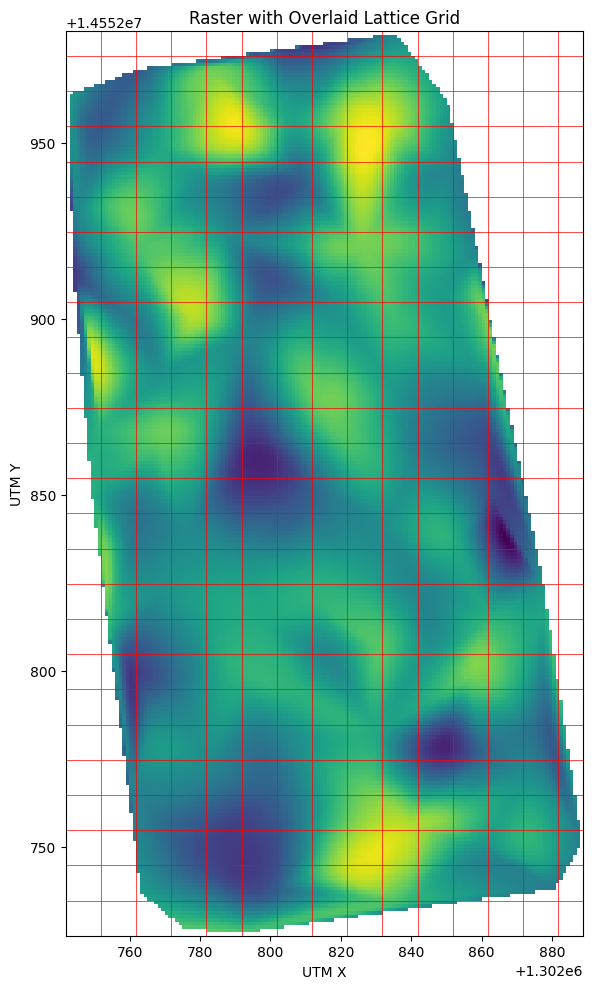

In [20]:
## Overlay a lattice over the raster data- ONLY VISUAL
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

# === FILES ===
RASTER_FILE = "interpolated_ph.tif"

# === GRID CONFIG ===
GRID_SPACING = 10  # meters
LINE_COLOR = "red"

# === LOAD RASTER ===
with rasterio.open(RASTER_FILE) as src:
    bounds = src.bounds
    fig, ax = plt.subplots(figsize=(10, 10))

    # Show the raster
    show(src, ax=ax, cmap="viridis")

    # Overlay grid
    xmin, ymin, xmax, ymax = bounds.left, bounds.bottom, bounds.right, bounds.top

    # Vertical lines
    for x in np.arange(xmin, xmax, GRID_SPACING):
        ax.axvline(x=x, color=LINE_COLOR, linewidth=0.5)

    # Horizontal lines
    for y in np.arange(ymin, ymax, GRID_SPACING):
        ax.axhline(y=y, color=LINE_COLOR, linewidth=0.5)

    ax.set_title("Raster with Overlaid Lattice Grid")
    ax.set_xlabel("UTM X")
    ax.set_ylabel("UTM Y")
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.savefig("raster_with_lattice_overlay.png", dpi=300)
    plt.show()


Assuming `corrected_merged_soil_plots.csv` contains a column named geometry with WKT strings and a CRS of EPSG:32616, here's how to load and plot the actual plot boundary lattice over the raster file.
However the geometry column in the CSV is currently in latitude/longitude format (EPSG:4326), but the raster is in UTM Zone 16N (EPSG:32616). So, we first need to align the overlay correctly.

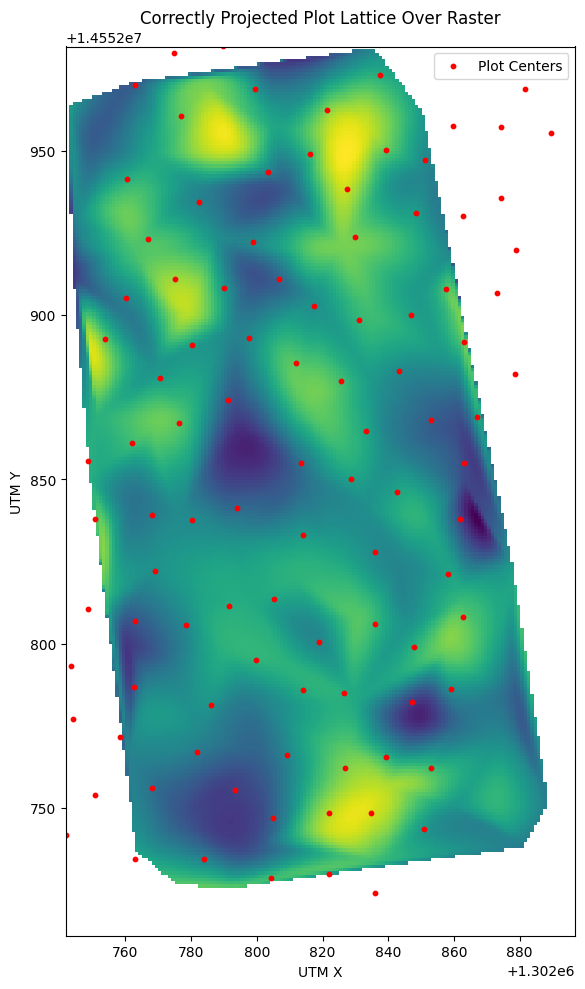

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely import wkt

# === CONFIG ===
CSV_PATH = "corrected_merged_soil_plots.csv"
RASTER_PATH = "interpolated_ph.tif"
ORIGINAL_CRS = "EPSG:4326"      # Lat/Lon (WGS84)
TARGET_CRS = "EPSG:32616"       # UTM Zone 16N

# === LOAD CSV WITH WKT GEOMETRY ===
df = pd.read_csv(CSV_PATH)
df["geometry"] = df["geometry"].apply(wkt.loads)

# Create GeoDataFrame with original CRS (WGS84)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=ORIGINAL_CRS)

# Transform to match raster projection (UTM)
gdf = gdf.to_crs(TARGET_CRS)

# === VISUALIZE OVER RASTER ===
with rasterio.open(RASTER_PATH) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap="viridis", title="Interpolated Raster (pH)")

    # Plot transformed point geometries
    gdf.plot(ax=ax, color="red", markersize=10, label="Plot Centers")

    ax.set_title("Correctly Projected Plot Lattice Over Raster")
    ax.set_xlabel("UTM X")
    ax.set_ylabel("UTM Y")
    ax.set_aspect("equal")
    ax.legend()

    plt.tight_layout()
    plt.savefig("overlay_lattice_projected_correctly.png", dpi=300)
    plt.show()


# **EXTRA CREDIT: 20 pnts**

Overlay the  Trialing Plot Lattice on top of the GeoTIFF generated above, and visualize with `rasterio`

📂 File 1: corrected_merged_soil_plots.csv

This file contains:

100 soil plot sample records.

A geometry column with POINT (Lon Lat) strings.

A SampleID column like S001, S002, etc.

Lat/Lon coordinates in columns such as:

Lat, Lon

Decimal_La, Decimal_Lo

It does not contain explicit PlotID, but it does contain geographic coordinates for each soil sample location.

📂 File 2: field_plot_coordinates_with_plotid.csv

This file contains:

96 rows corresponding to polygon vertices for 96 plots.

A column PlotID like P001, P002, ..., P096

VertexID: index of each polygon vertex (likely used to construct the boundary)

UTM coordinates:

X_UTM, Y_UTM

No direct match with SampleID, and no geometry column.

🔍 Analysis and Merge Strategy

Since there's no shared key (SampleID vs PlotID) and no shared geometry format (POINT vs polygon vertices), we can’t do a direct merge by ID. However, we can merge them spatially, by:

🧭 Step 1: Create geometry objects

Convert the POINTs in corrected_merged_soil_plots.csv to GeoDataFrame using geometry or Decimal_La/Decimal_Lo.

Convert field_plot_coordinates_with_plotid.csv into polygons by grouping rows by PlotID, using the ordered VertexID to form the polygon from X_UTM, Y_UTM.

🌐 Step 2: Reproject POINT GeoDataFrame

Points are currently in Lat/Lon (EPSG:4326).

Polygons are in UTM Zone 16N (EPSG:32616).

We'll convert the points to UTM so we can do a spatial join.

🔁 Step 3: Perform a Spatial Join

Once both GeoDataFrames are in the same CRS, we’ll use gpd.sjoin() to assign each soil sample (SampleID) to the nearest enclosing PlotID polygon.